In [2]:
# Upload your file from local system in Colab
from google.colab import files
uploaded = files.upload()

# After uploading, get the file name
import pandas as pd
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# Initial check
print(df.shape)
df.head()


Saving Infectious Disease 2001-2014.csv to Infectious Disease 2001-2014.csv
(141777, 10)


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,Total,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,Female,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,Male,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,Total,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,Female,145,17555714,0.826,0.697,0.972,


In [3]:
# Drop columns that are not needed for prediction
df = df.drop(columns=['CI.lower', 'CI.upper', 'Unstable'])

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Define input features and target
features = ['Disease', 'County', 'Year', 'Sex', 'Population']
target = 'Rate'  # or use 'Count' if you want to predict case numbers

X = df[features]
y = df[target]

# Display basic info
print("\nFeature data types:\n", X.dtypes)
print("\nTarget variable preview:\n", y.head())


Missing values:
 Disease       0
County        0
Year          0
Sex           0
Count         0
Population    0
Rate          0
dtype: int64

Feature data types:
 Disease       object
County        object
Year           int64
Sex           object
Population     int64
dtype: object

Target variable preview:
 0    1.654
1    1.015
2    2.125
3    1.265
4    0.826
Name: Rate, dtype: float64


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column types
categorical = ['Disease', 'County', 'Sex']
numerical = ['Year', 'Population']

# Fixed preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical),
    ('num', StandardScaler(), numerical)
])


In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# Create pipelines for each model
pipelines = {
    name: Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    for name, model in models.items()
}


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Store evaluation results
evaluation_results = {}

# Train and evaluate each model
for name, pipe in pipelines.items():
    print(f"\nTraining model: {name}")
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # Save results
    evaluation_results[name] = {
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    }

# Convert results to a DataFrame for display
eval_df = pd.DataFrame(evaluation_results).T
print("\nModel Evaluation Summary:")
display(eval_df)



Training model: RandomForest

Training model: GradientBoosting

Training model: DecisionTree

Model Evaluation Summary:


,R2 Score,MAE,RMSE
RandomForest,0.977722,1.297765,6.864584
GradientBoosting,0.914940,2.915880,13.413447
DecisionTree,0.967977,1.490812,8.230148


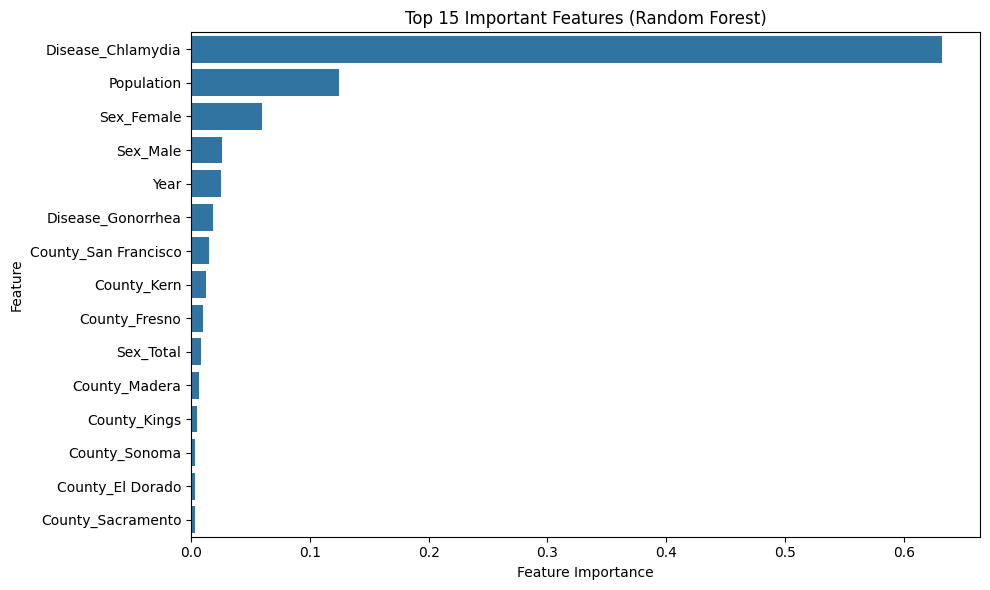

In [7]:
# Refit the Random Forest pipeline to extract trained components
rf_pipeline = pipelines['RandomForest']
rf_pipeline.fit(X_train, y_train)

# Extract one-hot encoded feature names
ohe = rf_pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(['Disease', 'County', 'Sex']).tolist()
all_feature_names = encoded_feature_names + ['Year', 'Population']

# Get feature importances
importances = rf_pipeline.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Top 15 Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


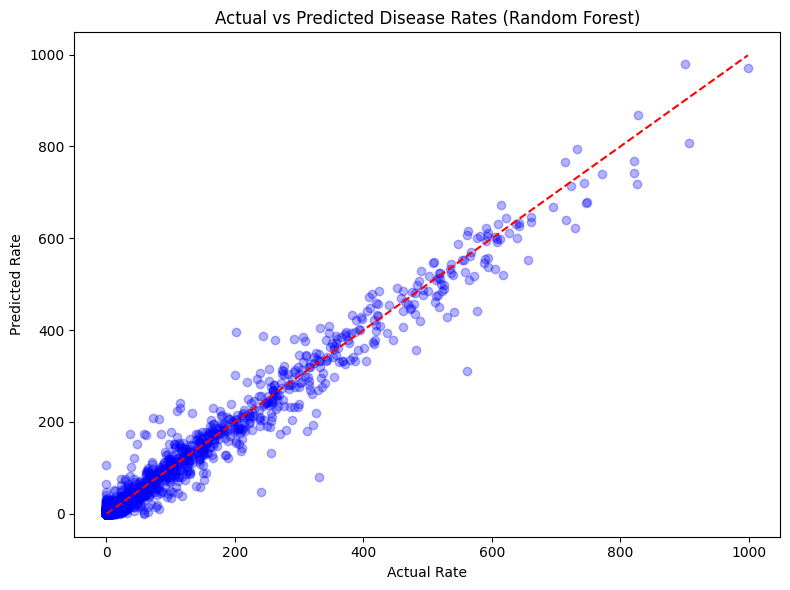

In [11]:
import matplotlib.pyplot as plt

y_pred = rf_pipeline.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rate')
plt.ylabel('Predicted Rate')
plt.title('Actual vs Predicted Disease Rates (Random Forest)')
plt.tight_layout()
plt.show()


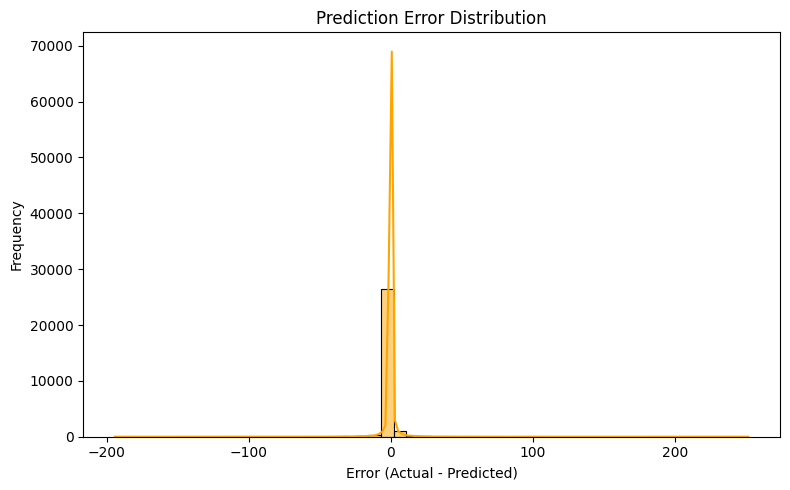

In [12]:
import seaborn as sns

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color='orange')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


<ipython-input-13-20e585a1f929>:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


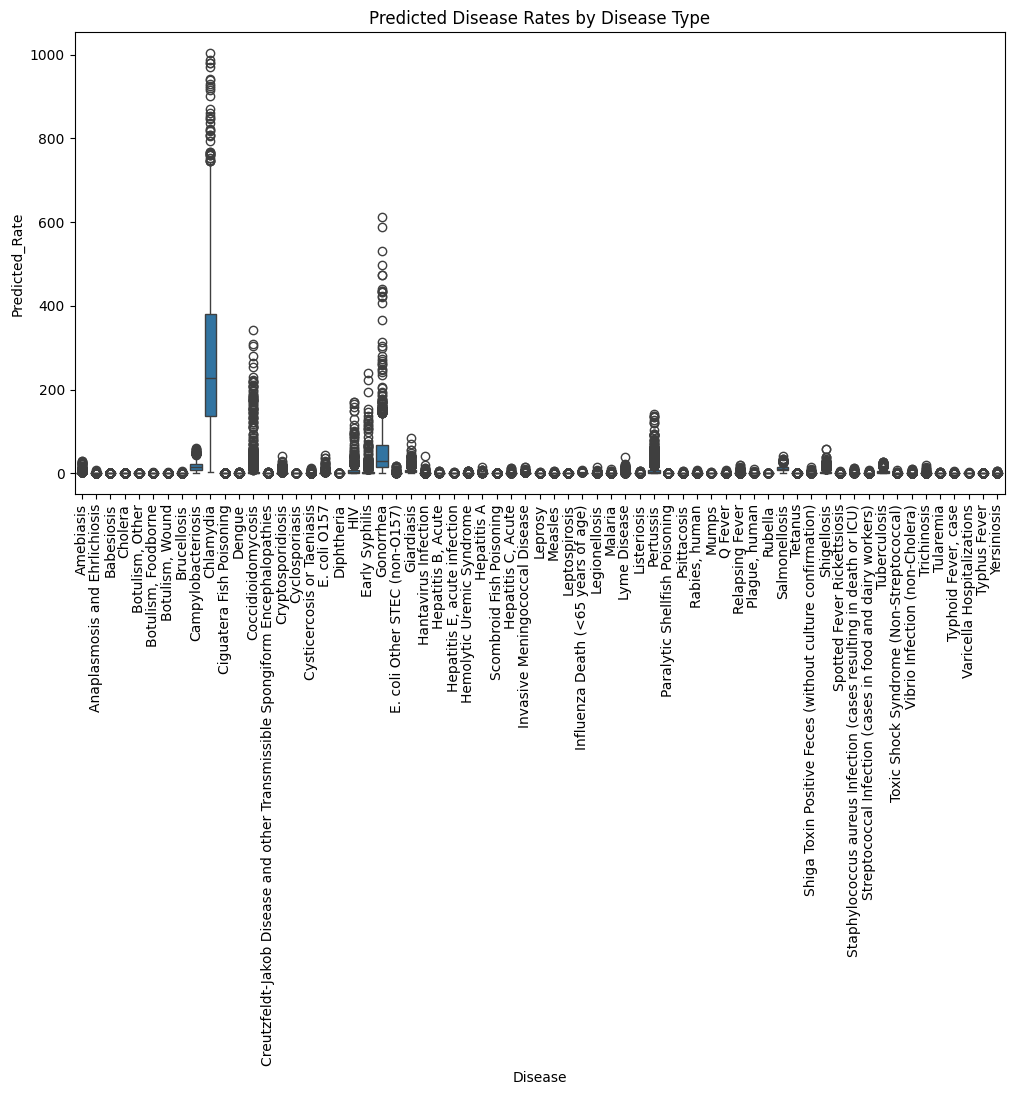

In [13]:
df['Predicted_Rate'] = rf_pipeline.predict(X)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Disease', y='Predicted_Rate', data=df)
plt.xticks(rotation=90)
plt.title("Predicted Disease Rates by Disease Type")
plt.tight_layout()
plt.show()


In [8]:
# Results Summary Text – Use this in your report
summary = """
Random Forest Regressor achieved the best performance with an R² score of 0.9777,
indicating it explained nearly 98% of the variance in disease rate prediction.

MAE (1.29) and RMSE (6.86) are low, showing minimal average and squared errors.

Feature importance analysis revealed that variables like certain counties,
specific diseases, and population size have the highest predictive power.

This validates that machine learning can accurately model complex health data,
making it useful for guiding public health interventions and targeting resources effectively.
"""

print(summary)



Random Forest Regressor achieved the best performance with an R² score of 0.9777, 
indicating it explained nearly 98% of the variance in disease rate prediction.

MAE (1.29) and RMSE (6.86) are low, showing minimal average and squared errors.

Feature importance analysis revealed that variables like certain counties, 
specific diseases, and population size have the highest predictive power.

This validates that machine learning can accurately model complex health data, 
making it useful for guiding public health interventions and targeting resources effectively.



In [9]:
import joblib

# Save the best-performing pipeline (Random Forest)
joblib.dump(rf_pipeline, 'random_forest_disease_model.pkl')

print("Model saved successfully as 'random_forest_disease_model.pkl'")


Model saved successfully as 'random_forest_disease_model.pkl'


In [10]:
# Predict disease rates on the entire dataset
df['Predicted_Rate'] = rf_pipeline.predict(X)

# Export for Tableau
df.to_csv('tableau_disease_data.csv', index=False)
print("Exported 'tableau_disease_data.csv' for use in Tableau")


Exported 'tableau_disease_data.csv' for use in Tableau


In [15]:
from google.colab import files
files.download('tableau_disease_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>